# Description

This work deals with the classification of handwritten numbers by a fully connected neural network (using GPU).

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.datasets

import warnings
warnings.filterwarnings("ignore")

# Tasks

Task 1. Classify images using a fully connected neural network (MNIST dataset).

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

__Data preparation__

In [3]:
mnist_train = torchvision.datasets.MNIST('./', download=True, train=True);
mnist_test = torchvision.datasets.MNIST('./', download=True, train=False);
X_train = mnist_train.train_data
y_train = mnist_train.train_labels
X_test = mnist_test.test_data
y_test = mnist_test.test_labels

In [4]:
# X_train and y_train dtypes
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [5]:
# for greater accuracy in calculations
X_train = X_train.float()
X_test = X_test.float()

In [6]:
# datasets shapes
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
torch.Size([60000]) torch.Size([10000])


tensor(5)


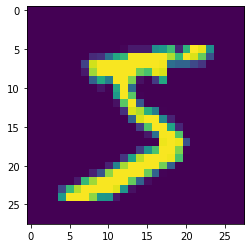

In [7]:
# display an example of the data
plt.imshow(X_train[0, :, :])
print(y_train[0])

In [8]:
# unrolling parameters
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [9]:
# updated datasets shapes
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([60000, 784]) torch.Size([10000, 784])
torch.Size([60000]) torch.Size([10000])


__Model__

In [10]:
class MNISTNet(torch.nn.Module):
    
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x

In [11]:
mnist_net = MNISTNet(100)
mnist_net

MNISTNet(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (ac1): Sigmoid()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

__Loss and optimizer__

In [12]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

__Device__

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
X_test = X_test.to(device)
y_test = y_test.to(device)
mnist_net = mnist_net.to(device)

__Model training__

In [15]:
batch_size = 100
test_accuracy_history = []
test_loss_history = []
train_loss_history = []

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    train_loss_history.append(loss_value)

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)

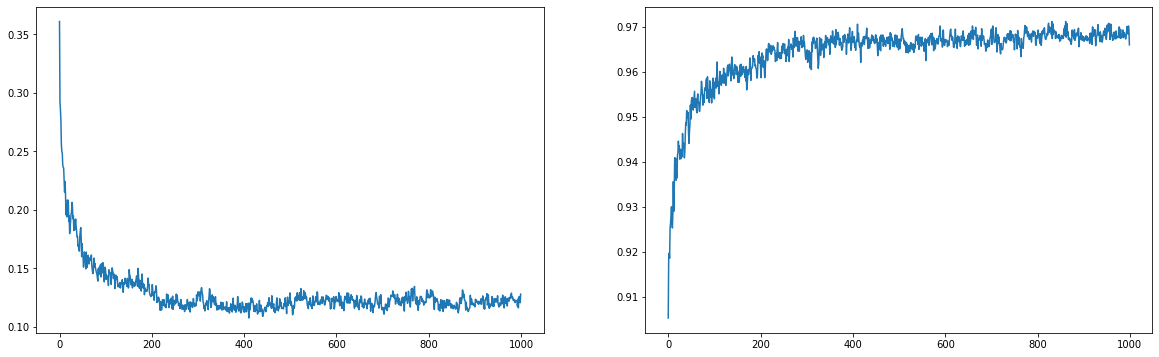

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].plot(test_loss_history)
ax[1].plot(test_accuracy_history)

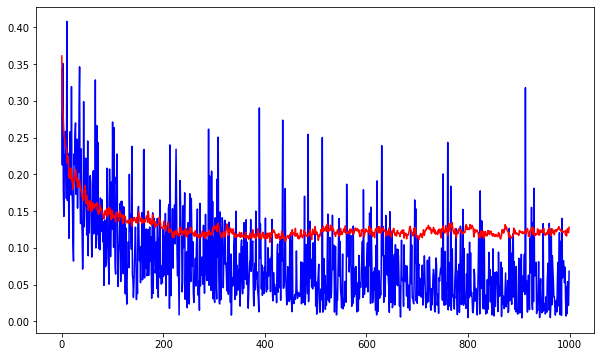

In [17]:
fig = plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, 'b')
plt.plot(test_loss_history, 'r')

Task 2. Implement the functionality of torch.nn.Linear from scratch and compare with the original.

In [18]:
class linear_transformation():
    
    def __init__(self, in_features, out_features, bias=True):
        self.in_features = in_features
        self.out_features = out_features
        self.bias = np.ones((self.out_features)) if bias else None
        self.W = np.ones((self.in_features, self.out_features))

    def forward(self, X):
        if self.bias is not None:
            self.Y = X.dot(self.W) + self.bias
        else:
            self.Y = X.dot(self.W)
        return self.Y

In [19]:
# implemented functionality
lin_obj = linear_transformation(100, 50)
x = np.ones((100))
y = lin_obj.forward(x)

# original functionality
lin_obj_torch = torch.nn.Linear(100, 50)
x_torch = torch.Tensor(np.ones((100)))
y_torch = lin_obj_torch.forward(x_torch)

# comparison
print(y.shape, y_torch.shape)

(50,) torch.Size([50])


Task 3. Suppose we have 1 object x at the input with two components. We will transfer it to a fully connected layer with 3 neurons and get 3 outputs. Then write the same functionality using matrix multiplication. And check the calculation of the derivative.

In [20]:
x = torch.tensor([[10., 20.]])
w = torch.tensor([[11., 12.], [21., 22.], [31., 32]])
b = torch.tensor([[31., 32., 33.]])

In [21]:
# original fc layer
fc = torch.nn.Linear(2, 3)
fc.weight.data = w
fc.bias.data = b
fc_out = fc(x)
fc_out_summed = fc_out.sum()
fc_out_summed.backward()

weight_grad = fc.weight.grad
bias_grad = fc.bias.grad

In [22]:
# matrix multiplication
w.requires_grad_(True)
b.requires_grad_(True)

fc_out_alternative = torch.matmul(x, torch.transpose(w, 0, 1)) + b
fc_out_alternative__summed = fc_out_alternative.sum()
fc_out_alternative__summed.backward()

In [23]:
# check the match
print(fc_out == fc_out_alternative)
print('fc_weight_grad:', weight_grad)
print('our_weight_grad:', w.grad)
print('fc_bias_grad:', bias_grad)
print('out_bias_grad:', b.grad)

tensor([[True, True, True]])
fc_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
our_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
fc_bias_grad: tensor([[1., 1., 1.]])
out_bias_grad: tensor([[1., 1., 1.]])
